In [1]:
import hmclab
import numpy, matplotlib.pyplot as plt

%matplotlib notebook

# Autotuning the mass matrix

When the posterior contains complex or unknown correlations in parameters (e.g. when two parameters trade-off) we can try to update the mass matrix on the go. For this, we use an Broyden-Fletcher-Goldfarb-Shanno type mass matrix.

Let us first investigate the behaviour of a unit mass matrix on a strongly correlated distribution. Below a visualization of the distribution (which we normally wouldn't compute a-priori):

<IPython.core.display.Javascript object>


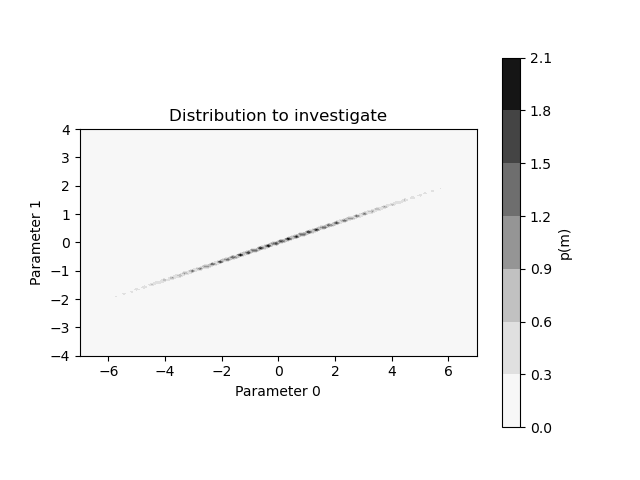

In [2]:
covariance = numpy.array([[9, 2.999], [2.999, 1]])

CorrelatedNormal_2d = hmclab.Distributions.Normal([0, 0], covariance)

domain = [-7, 7, -4, 4]

x1s = numpy.linspace(domain[0], domain[1], 100)
x2s = numpy.linspace(domain[2], domain[3], 100)

grid = numpy.stack(numpy.meshgrid(x1s, x2s))

background_image = numpy.empty_like(grid[0, :, :])

for ix1 in range(100):
    for ix2 in range(100):
        background_image[ix1, ix2] = CorrelatedNormal_2d.misfit(grid[:, ix1, ix2, None])


background = (x1s, x2s, background_image)

plt.figure()
ax = plt.gca()
plt.title("Distribution to investigate")

plt.contourf(
    x1s,
    x2s,
    numpy.exp(-background_image)
    / numpy.sum(numpy.exp(-background_image) * (x1s[1] - x1s[0]) * (x2s[1] - x2s[0])),
    cmap=plt.get_cmap("Greys"),
)
plt.gca().set_aspect(1)
plt.xlabel("Parameter 0")
plt.ylabel("Parameter 1")
cbar = plt.colorbar()
_ = cbar.ax.set_ylabel("p(m)")
ax.set_aspect("equal")

plt.show()

This distribution is strongly shaped. Let's sample this using a unit mass matrix with some of the tricks we learned in the last tutorials (autotuning of stepsize, randomizing trajectory length):

<IPython.core.display.Javascript object>


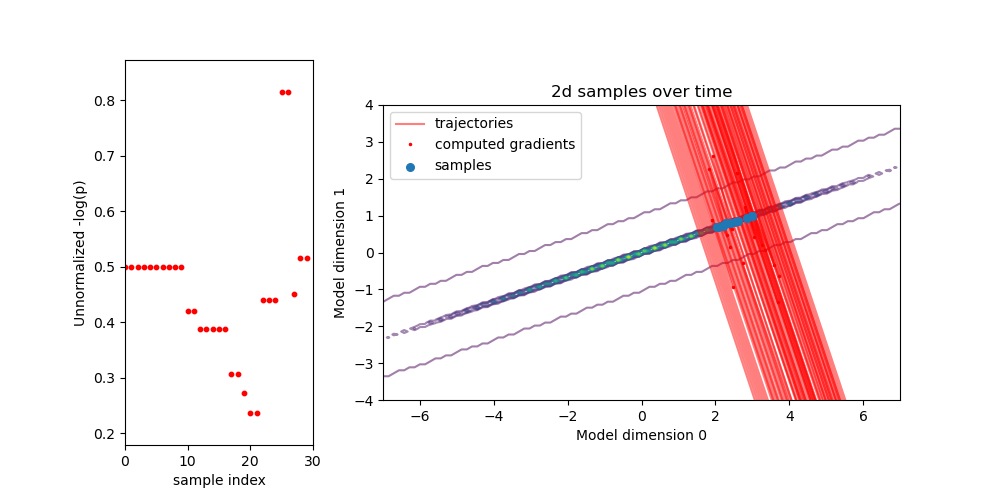

Tot. acc rate: 0.00. Progress:   0%|                     | 0/30 [00:00<?, ?it/s]

In [3]:
stepsize = 0.1
amount_of_steps = 10
proposals = 30
randomize_stepsize = True
initial_model = numpy.array([3, 1])
initial_model.shape = (initial_model.size, 1)
unit_mass = hmclab.MassMatrices.Unit(dimensions=2)

sampler_unit = hmclab.Samplers.HMC_visual(
    animate_proposals=True,
    animation_domain=domain,
    leave_proposal_animation=True,
    seed=48,
    background=background,
)


_ = sampler_unit.sample(
    "bin_samples/tutorial_1c_samples.h5",
    CorrelatedNormal_2d,
    stepsize=stepsize,
    randomize_stepsize=randomize_stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    initial_model=initial_model,
    mass_matrix=unit_mass,
    autotuning=True,
    overwrite_existing_file=True,
)

We see the typical inefficient behaviour of improperly tuned mass matrices, i.e. oscillations that are more frequent in one of the two dimenions. In fact, on Gaussian distributions, trajectories seem to always perfectly mimick Lissajous curves. In this case, the posterior is so strongly correlated that the sampler first has to autotune its stepsize strongly, before any moves can be made. 

Let's now create a BFGS-style mass matrix. It's general operations is as follows:

- Collect all positions and gradients during one trajectory;
- After accepting a sample, update the current mass matrix with the collected positions/gradients;
- After rejecting a sample, do nothing;
- Only update if the resulting matrix is positive definite;

We initialize this matrix using an identity matrix, and an initial model and gradient. One can also initialize the matrix with any other positive definite matrix, allowing one to inject prior knowledge on the distribution to accelerate the autotuning.

Let's see the results for our target distribution:

<IPython.core.display.Javascript object>


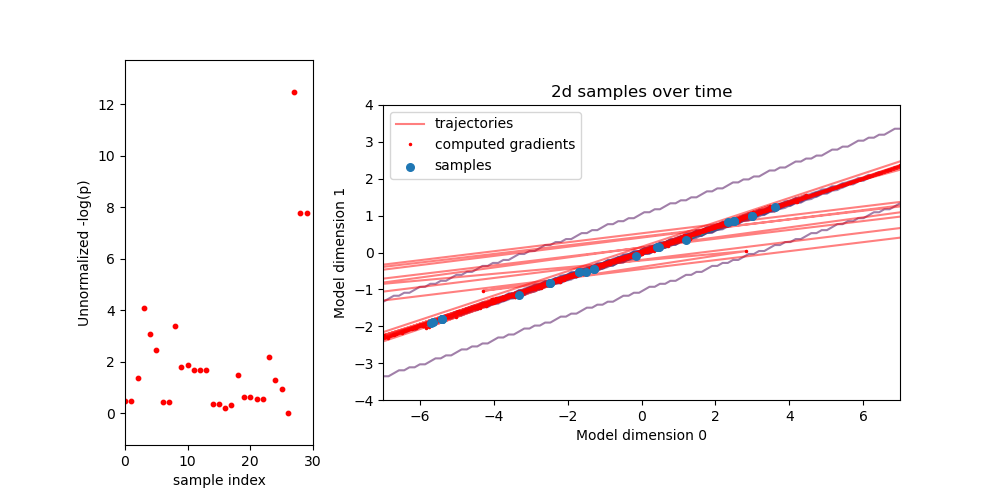

Tot. acc rate: 0.00. Progress:   0%|                     | 0/30 [00:00<?, ?it/s]

In [4]:
bfgs_mass = hmclab.MassMatrices.BFGS(
    2,
    numpy.ones((2, 1)) * 2,
    CorrelatedNormal_2d.gradient(numpy.ones((2, 1))) * 2,
    greedy=False,
)


sampler_bfgs = hmclab.Samplers.HMC_visual(
    animate_proposals=True,
    animation_domain=domain,
    leave_proposal_animation=True,
    seed=48,
    background=background,
)

_ = sampler_bfgs.sample(
    "bin_samples/tutorial_1_samples.h5",
    CorrelatedNormal_2d,
    stepsize=stepsize,
    randomize_stepsize=randomize_stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    initial_model=initial_model,
    mass_matrix=bfgs_mass,
    autotuning=True,
    overwrite_existing_file=True,
)

Hopefully one sees that the trajectories in this example are oscillating with more comparable frequency in both dimensions. However, this frequency does alter per trajectory, as the mass matrix keeps updating. We can, after some samples, investigate the resulting mass matrix, original covariance, and update statistics:

In [5]:
print(
    "Covariance matrices:\r\n",
    "BFGS-mass\r\n",
    sampler_bfgs.mass_matrix.Minv,
    "\r\n\r\n",
    "Distribution\r\n",
    CorrelatedNormal_2d.covariance,
    "\r\n\r\n",
    f"Succesful updates: "
    f"{sampler_bfgs.mass_matrix.succesful_updates}/{sampler_bfgs.mass_matrix.attempted_updates}\r\n",
)


def cov_to_cor(M):
    D = numpy.diag(numpy.sqrt(numpy.diag(M)))
    DInv = numpy.linalg.inv(D)
    R = DInv @ M @ DInv
    return R


Minv_cor = cov_to_cor(sampler_bfgs.mass_matrix.Minv)
Norm_cor = cov_to_cor(CorrelatedNormal_2d.covariance)

print(
    "Correlation matrices:\r\n",
    "BFGS-mass\r\n",
    Minv_cor,
    "\r\n\r\n",
    "Distribution\r\n",
    Norm_cor,
)

Covariance matrices:
 BFGS-mass
 [[1.7484475  0.58521713]
 [0.58521713 0.19612687]] 

 Distribution
 [[9.    2.999]
 [2.999 1.   ]] 

 Succesful updates: 220/220

Correlation matrices:
 BFGS-mass
 [[1.         0.99936049]
 [0.99936049 1.        ]] 

 Distribution
 [[1.         0.99966667]
 [0.99966667 1.        ]]


That is a decent approximation of the covariance of the target distribution. More importantly, the correlation structure in either covariance matrix is very similar, and this is essential to an efficiently tuned sampler. Because the acceptance rate is not 10, not all updates are accepted.

Now let's see how these two methods quantatively perform. To do this, we start out with making an equal amount of proposals using both plain HMC (untuned mass) and BFGS-tuned HMC.

In [6]:
stepsize = 0.1
amount_of_steps = 10
randomize_stepsize = True
proposals = 10000

initial_model = numpy.array([0, 0])
initial_model.shape = (initial_model.size, 1)
unit_mass = hmclab.MassMatrices.Unit(dimensions=2)
bfgs_mass = hmclab.MassMatrices.BFGS(
    2, initial_model, CorrelatedNormal_2d.gradient(numpy.ones((2, 1)))
)

sampler_unit = hmclab.Samplers.HMC(seed=48)
sampler_bfgs = hmclab.Samplers.HMC(seed=48)


sampler_unit.sample(
    "bin_samples/tutorial_6_many_unit.h5",
    CorrelatedNormal_2d,
    stepsize=stepsize,
    randomize_stepsize=randomize_stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    initial_model=initial_model,
    mass_matrix=unit_mass,
    autotuning=True,
    overwrite_existing_file=True,
)

sampler_bfgs.sample(
    "bin_samples/tutorial_6_many_bfgs.h5",
    CorrelatedNormal_2d,
    stepsize=stepsize,
    randomize_stepsize=randomize_stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    initial_model=initial_model,
    mass_matrix=bfgs_mass,
    autotuning=True,
    overwrite_existing_file=True,
)

Tot. acc rate: 0.00. Progress:   0%|                  | 0/10000 [00:00<?, ?it/s]

Tot. acc rate: 0.00. Progress:   0%|                  | 0/10000 [00:00<?, ?it/s]

Matrix is not positive definite
Relevant quantities (s.T @ y, m):
[[6.97146245e-05]] [[0.0250465 ]
 [0.00834327]]
Matrix is not positive definite
Relevant quantities (s.T @ y, m):
[[0.00062675]] [[0.07509869]
 [0.02501621]]
Matrix is not positive definite
Relevant quantities (s.T @ y, m):
[[0.00173719]] [[0.12502851]
 [0.04164839]]


A few things to note:

1. Because the stepsize is already autotuned, both samplers will hover around an acceptance rate of aobut 0.64-0.66.
2. The unit mass sampler is much faster per sample, as it does not need to compute updates.
3. For the BFGS updating, we got 3 error messages regarding non-positive definite updates. The BFGS mass matrix will not do those updates.

Let's first investigate how the autotuned mass matrix looks:

In [7]:
print(
    "Covariance matrices:\r\n",
    "BFGS-mass\r\n",
    sampler_bfgs.mass_matrix.Minv,
    "\r\n\r\n",
    "Distribution\r\n",
    CorrelatedNormal_2d.covariance,
    "\r\n\r\n",
    f"Succesful updates: "
    f"{sampler_bfgs.mass_matrix.succesful_updates}/{sampler_bfgs.mass_matrix.attempted_updates}\r\n",
)


def cov_to_cor(M):
    D = numpy.diag(numpy.sqrt(numpy.diag(M)))
    DInv = numpy.linalg.inv(D)
    R = DInv @ M @ DInv
    return R


Minv_cor = cov_to_cor(sampler_bfgs.mass_matrix.Minv)
Norm_cor = cov_to_cor(CorrelatedNormal_2d.covariance)

print(
    "Correlation matrices:\r\n",
    "BFGS-mass\r\n",
    Minv_cor,
    "\r\n\r\n",
    "Distribution\r\n",
    Norm_cor,
)

Covariance matrices:
 BFGS-mass
 [[4.56522527 1.51450452]
 [1.51450452 0.50278024]] 

 Distribution
 [[9.    2.999]
 [2.999 1.   ]] 

 Succesful updates: 65127/65130

Correlation matrices:
 BFGS-mass
 [[1.         0.99965552]
 [0.99965552 1.        ]] 

 Distribution
 [[1.         0.99966667]
 [0.99966667 1.        ]]


Not all updates to the BFGS mass have been accepted, as some would result in a non positive definite matrix. The correlation structure is now almost identical, which is what should give us sampling efficiency. Note that the absolute value of the correlation matrix does not matter much, as it inversely trades off with the stepsize. Hence, an HMC sampler tuned with mass matrix $M$ with a stepsize $E$ will yield **exactly** the same dynamics / proposals as a chain using $M*2$ and $E/2$.

Now let's look at the results of sampling, by comparing the means, covariances and 2d marginals of both algorithms.

Sampling covariance unit mass:
 [[5.91673634 1.97175718]
 [1.97175718 0.65769309]] 

Sampling covariance BFGS mass:
 [[58.86491558 19.57477256]
 [19.57477256  6.51444232]]


Sampling mean unit mass:
 [-0.25632632 -0.08497851] 
Sampling mean BFGS mass:
 [-0.19299679 -0.06176563]


<IPython.core.display.Javascript object>


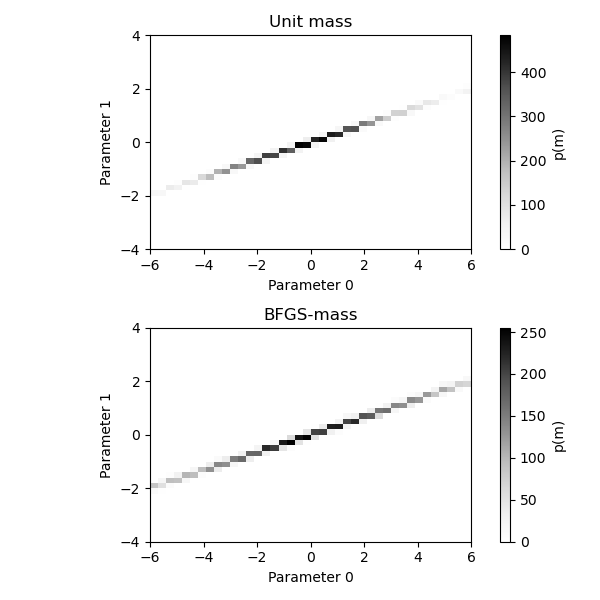

In [8]:
with hmclab.Samples(sampler_unit.samples_filename) as samples_many_unit, hmclab.Samples(
    sampler_bfgs.samples_filename
) as samples_many_bfgs:

    print(
        "Sampling covariance unit mass:\r\n",
        numpy.cov(samples_many_unit[:2, :]),
        "\r\n\r\nSampling covariance BFGS mass:\r\n",
        numpy.cov(samples_many_bfgs[:2, :]),
    )
    print(
        "\r\n\r\nSampling mean unit mass:\r\n",
        numpy.mean(samples_many_unit[:2, :], axis=1),
        "\r\nSampling mean BFGS mass:\r\n",
        numpy.mean(samples_many_bfgs[:2, :], axis=1),
    )

    plt.figure(figsize=(6, 6))
    plt.subplot(212)
    plt.gca().set_aspect("equal")
    plt.title("BFGS-mass")
    plt.hist2d(
        samples_many_bfgs[0, :],
        samples_many_bfgs[1, :],
        range=([-6, 6], [-4, 4]),
        bins=40,
        cmap=plt.get_cmap("Greys"),
    )
    plt.xlabel("Parameter 0")
    plt.ylabel("Parameter 1")
    cbar = plt.colorbar()
    _ = cbar.ax.set_ylabel("p(m)")
    ax.set_aspect("equal")
    plt.subplot(211)
    plt.gca().set_aspect("equal")
    plt.title("Unit mass")
    plt.hist2d(
        samples_many_unit[0, :],
        samples_many_unit[1, :],
        range=([-6, 6], [-4, 4]),
        bins=40,
        cmap=plt.get_cmap("Greys"),
    )
    plt.xlabel("Parameter 0")
    plt.ylabel("Parameter 1")
    cbar = plt.colorbar()
    _ = cbar.ax.set_ylabel("p(m)")
    ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()

Now comes something interesting. We see:
    
1. The covariances form the unit mass are **much** more accurate.
2. The marginals look almost the same.
    
How can this be? The truth hides in the misfit, or negative log posterior:

<IPython.core.display.Javascript object>


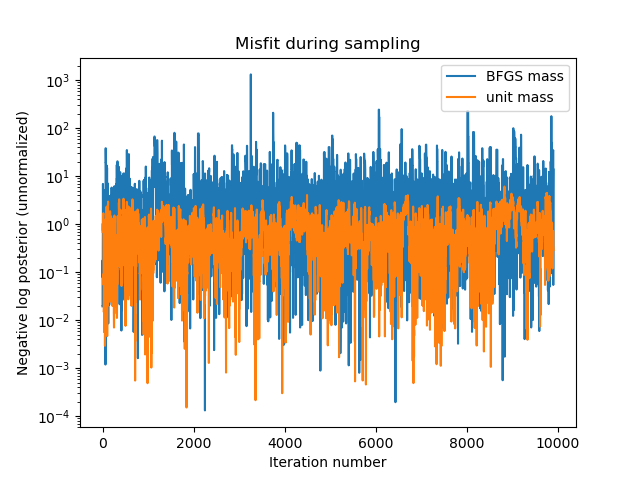

In [9]:
with hmclab.Samples(
    sampler_unit.samples_filename, burn_in=100
) as samples_many_unit, hmclab.Samples(
    sampler_bfgs.samples_filename, burn_in=100
) as samples_many_bfgs:
    plt.figure()
    plt.semilogy((samples_many_bfgs[-1, :]), label="BFGS mass")
    plt.semilogy((samples_many_unit[-1, :]), label="unit mass")

    plt.gca().annotate(
        "Heavy tail favouring",
        xy=(1800, 5e3),
        xycoords="data",
        xytext=(2500, 5e3),
        textcoords="data",
        arrowprops=dict(arrowstyle="->", color="blue", lw=1.5, ls="-"),
    )
    plt.xlabel("Iteration number")
    plt.ylabel("Negative log posterior (unnormalized)")
    plt.title("Misfit during sampling")
    plt.legend()
    plt.show()

It turns out that the algorithm using the BFGS mass matrix samples much higher misfit values. It effectively heavily favours the tails of the distribution, thereby not sampling i.i.d. from the distribution. 

This is caused by the fact that updating every sample breaks the Markov property (history-agnostic) of the sampler. Although it is very good at moving over the distribution, it is not visiting models proportional to their probability. 

We can investigate this more by looking at the distribution of misfits, compared to the same distribution from "true" samples, generated by an RNG:

<IPython.core.display.Javascript object>


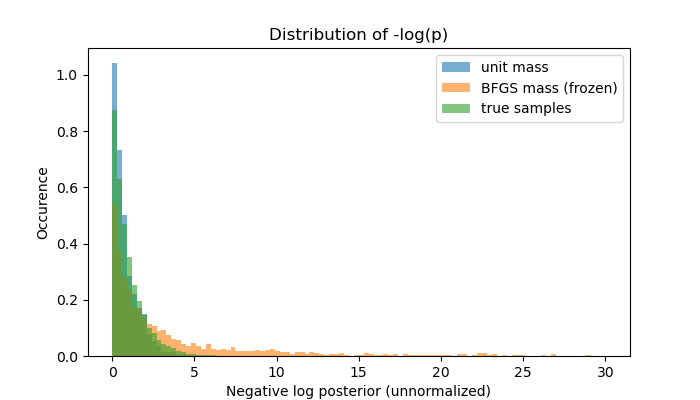

In [22]:
with hmclab.Samples(
    sampler_unit.samples_filename, burn_in=100
) as samples_many_unit, hmclab.Samples(
    sampler_bfgs.samples_filename, burn_in=100
) as samples_many_bfgs:
    plt.figure(figsize=(7, 4))
    _, bins, _ = plt.hist(
        (samples_many_unit[-1, :]),
        label="unit mass",
        bins=100,
        range=[0, 30],
        alpha=0.6,
        density=True,
    )
    _, bins, _ = plt.hist(
        (samples_many_bfgs[-1, :]),
        label="BFGS mass (frozen)",
        bins=bins,
        alpha=0.6,
        density=True,
    )

    true_samples = CorrelatedNormal_2d.generate(samples_many_bfgs.numpy.shape[-1])

    true_samples_misfit = 0.5 * (
        true_samples * (CorrelatedNormal_2d.inverse_covariance @ true_samples)
    ).sum(axis=0)

    _, bins, _ = plt.hist(
        true_samples_misfit,
        label="true samples",
        bins=bins,
        alpha=0.6,
        density=True,
    )
    plt.title("Distribution of -log(p)")
    plt.ylabel("Occurence")
    plt.xlabel("Negative log posterior (unnormalized)")

    plt.legend()

Again, the BFGS mass matrix seems to disproportionally sample the tail of the distribution.

# Freezing

One remedy to make the sampler again a true MCMC sampler with the Markov property is to freeze the mass matrix after using it on a distribution. This consolidates the current state of the BFGS mass matrix into a normal mass matrix.

In [11]:
proposals = 10000
sampler_unit_2 = hmclab.Samplers.HMC(seed=48)
sampler_bfgs_2 = hmclab.Samplers.HMC(seed=48)

frozen_mass = bfgs_mass.freeze(cast=True)

sampler_unit_2.sample(
    "bin_samples/tutorial_6_many_unit_2.h5",
    CorrelatedNormal_2d,
    stepsize=stepsize,
    randomize_stepsize=randomize_stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    initial_model=initial_model,
    mass_matrix=unit_mass,
    autotuning=True,
    overwrite_existing_file=True,
)

sampler_bfgs_2.sample(
    "bin_samples/tutorial_6_many_bfgs_frozen_2.h5",
    CorrelatedNormal_2d,
    stepsize=stepsize,
    randomize_stepsize=randomize_stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    initial_model=initial_model,
    mass_matrix=frozen_mass,
    autotuning=True,
    overwrite_existing_file=True,
)

Tot. acc rate: 0.00. Progress:   0%|                  | 0/10000 [00:00<?, ?it/s]

Tot. acc rate: 0.00. Progress:   0%|                  | 0/10000 [00:00<?, ?it/s]

Here it is already obvious that the freezing speeds up the sampling, as no updates need to be done. However, since we have off-diagonal elements, the computations relating to the mass matrix are still slightly slower than those of the unit (diagonal) mass matrix.

Let's investigate the same quantities:

Sampling covariance unit mass:
 [[5.91673634 1.97175718]
 [1.97175718 0.65769309]] 

Sampling covariance BFGS mass:
 [[9.52618309 3.1746716 ]
 [3.1746716  1.05865976]]


Sampling mean unit mass:
 [-0.25632632 -0.08497851] 
Sampling mean BFGS mass:
 [0.07891803 0.02687828]


<IPython.core.display.Javascript object>


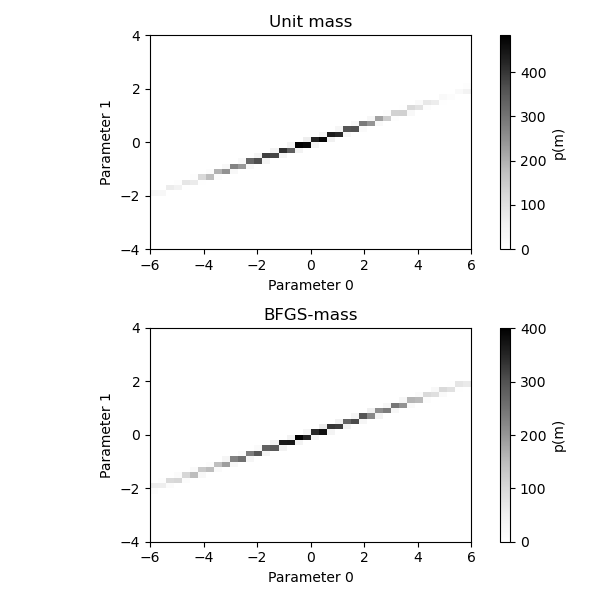

In [12]:
with hmclab.Samples(
    sampler_unit_2.samples_filename
) as samples_many_unit, hmclab.Samples(
    sampler_bfgs_2.samples_filename
) as samples_many_bfgs:

    print(
        "Sampling covariance unit mass:\r\n",
        numpy.cov(samples_many_unit[:2, :]),
        "\r\n\r\nSampling covariance BFGS mass:\r\n",
        numpy.cov(samples_many_bfgs[:2, :]),
    )
    print(
        "\r\n\r\nSampling mean unit mass:\r\n",
        numpy.mean(samples_many_unit[:2, :], axis=1),
        "\r\nSampling mean BFGS mass:\r\n",
        numpy.mean(samples_many_bfgs[:2, :], axis=1),
    )

    plt.figure(figsize=(6, 6))
    plt.subplot(212)
    plt.gca().set_aspect("equal")
    plt.title("BFGS-mass")
    plt.hist2d(
        samples_many_bfgs[0, :],
        samples_many_bfgs[1, :],
        range=([-6, 6], [-4, 4]),
        bins=40,
        cmap=plt.get_cmap("Greys"),
    )
    plt.xlabel("Parameter 0")
    plt.ylabel("Parameter 1")
    cbar = plt.colorbar()
    _ = cbar.ax.set_ylabel("p(m)")
    ax.set_aspect("equal")
    plt.subplot(211)
    plt.gca().set_aspect("equal")
    plt.title("Unit mass")
    plt.hist2d(
        samples_many_unit[0, :],
        samples_many_unit[1, :],
        range=([-6, 6], [-4, 4]),
        bins=40,
        cmap=plt.get_cmap("Greys"),
    )
    plt.xlabel("Parameter 0")
    plt.ylabel("Parameter 1")
    cbar = plt.colorbar()
    _ = cbar.ax.set_ylabel("p(m)")
    ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()

Now, although the 2d marginals look very similar, the resulting means and covariances are much more accurate for the tuned mass matrix. Let's look at the misfit during sampling:

<IPython.core.display.Javascript object>


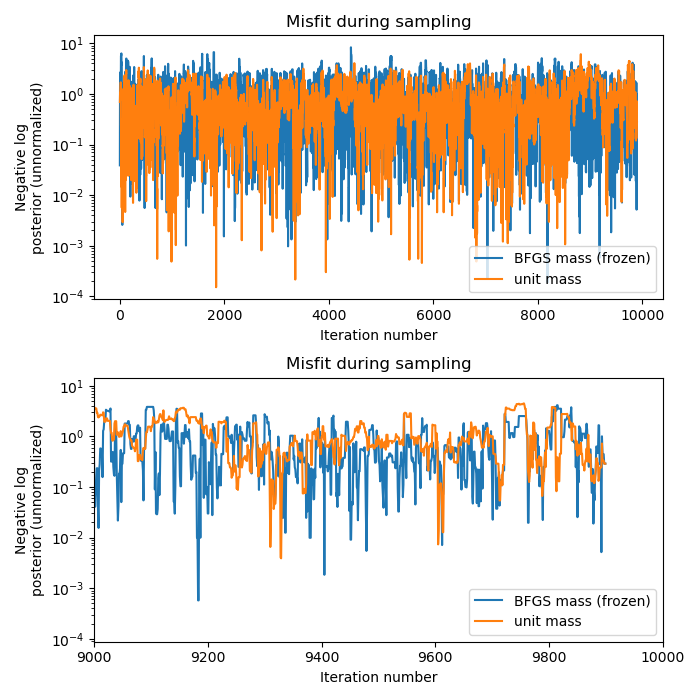

In [13]:
with hmclab.Samples(
    sampler_unit_2.samples_filename, burn_in=100
) as samples_many_unit, hmclab.Samples(
    sampler_bfgs_2.samples_filename, burn_in=100
) as samples_many_bfgs:
    plt.figure(figsize=(7, 7))
    plt.subplot(211)

    plt.semilogy((samples_many_bfgs[-1, :]), label="BFGS mass (frozen)")
    plt.semilogy((samples_many_unit[-1, :]), label="unit mass")

    plt.gca().annotate(
        "Heavy tail favouring",
        xy=(1800, 5e3),
        xycoords="data",
        xytext=(2500, 5e3),
        textcoords="data",
        arrowprops=dict(arrowstyle="->", color="blue", lw=1.5, ls="-"),
    )
    plt.xlabel("Iteration number")
    plt.ylabel("Negative log\nposterior (unnormalized)")
    plt.title("Misfit during sampling")
    plt.legend()

    plt.subplot(212)
    plt.semilogy((samples_many_bfgs[-1, :]), label="BFGS mass (frozen)")
    plt.semilogy((samples_many_unit[-1, :]), label="unit mass")
    plt.xlim([9000, 10000])

    plt.gca().annotate(
        "Heavy tail favouring",
        xy=(1800, 5e3),
        xycoords="data",
        xytext=(2500, 5e3),
        textcoords="data",
        arrowprops=dict(arrowstyle="->", color="blue", lw=1.5, ls="-"),
    )
    plt.xlabel("Iteration number")
    plt.ylabel("Negative log\nposterior (unnormalized)")
    plt.title("Misfit during sampling")
    plt.legend()
    plt.tight_layout()
    plt.show()

Two important characteristics:

1. The sampler using the BFGS mass matrix does not sampler the tails too much anymore.
2. The mixing of the sampler using the BFGS mass matrix seems to be much better than that of the unit mass matrix (more variation in misfit). This likely results in less correlation, and more efficient sampling.

Now, if we compare the distribution of the misfits, we can rest assured that the sampler with the BFGS tuned frozen mass matrix does work properly:

<IPython.core.display.Javascript object>


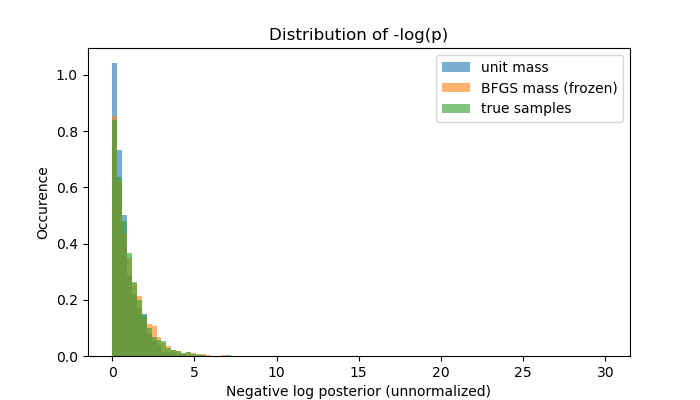

In [21]:
with hmclab.Samples(
    sampler_unit_2.samples_filename, burn_in=100
) as samples_many_unit, hmclab.Samples(
    sampler_bfgs_2.samples_filename, burn_in=100
) as samples_many_bfgs:
    plt.figure(figsize=(7, 4))
    _, bins, _ = plt.hist(
        (samples_many_unit[-1, :]),
        label="unit mass",
        bins=100,
        range=[0, 30],
        alpha=0.6,
        density=True,
    )
    _, bins, _ = plt.hist(
        (samples_many_bfgs[-1, :]),
        label="BFGS mass (frozen)",
        bins=bins,
        alpha=0.6,
        density=True,
    )
    _, bins, _ = plt.hist(
        true_samples_misfit,
        label="true samples",
        bins=bins,
        alpha=0.6,
        density=True,
    )
    plt.title("Distribution of -log(p)")
    plt.ylabel("Occurence")
    plt.xlabel("Negative log posterior (unnormalized)")
    plt.legend()

From the findings in this notebook, we recommend to run a two stage inference: one where the mass matrix of the chain is tuned, followed by a frozen mass matrix appraisal.

When the posterior is non-linear, i.e. the correlation structure varies from point to point, it might be relevant to either run multiple chains from different points, or to "flicker" the autotuning; every $N$ samples, tune the mass matrix for a few ($F<<N$) samples.